# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 14/07/2024</small></i></div>

Este notebook tiene como objetivo la definición de la última fase del modelo de difusión, es decir, el entrenamiento un modelo DDPM.

Para ello, este notebook se dividirá en las siguientes secciones:

- [0. Imports](#-0.-Imports)

- [1. Carga del dataset](#-1.-Carga-del-dataset)

- [2. Modelo](#-2.-Modelo)

  - [2.1. Entrenamiento](#21-entrenamiento)
  - [2.2 Evaluación del modelo](#22-evaluación-del-modelo)
  - [2.3 Guardado del modelo](#23-guardado-del-modelo)

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()``. Para implementar el training se ha usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido la funcionalidad extra que permiten guardar cada 100 epochs los pesos del modelo en un fichero con extensión `.weights.h5`. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo o para comparar la generación de muestras a lo largo del entrenamiento, entre otras cosas. Además, también se añade la posibilidad de, cada N epochs (siendo N un número determinado por el usuario), hacer una muestra donde se plotea el proceso de sampling desde $t = T$ hasta $t = 0$ y siempre partiendo desde el mismo ruido, todo ello, para ver como evoluciona el entrenamiento a lo largo de los epochs.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Este proceso de guardado se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde mas o menos se quedó sin problemas.
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
>
> Para más información: `src/model/model_callbacks`.
</small></i>

# 0. Imports

Una vez introducido el objetivo de este notebook, se importan las librerías necesarias para el desarrollo del apartado.

---

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-07-14 09:28:20.381135: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 09:28:20.412627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 09:28:21.642698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 09:28:21.646544: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Carga del dataset

En este apartado, se cargará el dataset que se usará para entrenar el modelo de difusión. En este caso, se usará el tf.data.Dataset creado en los notebooks anteriores. Pero con la ligera diferencia de que esta vez dividiremos dicho dataset en train y test para posteriormente al entreno del modelo evaluarlo usando el conjunto de test para garantizar el buen entrenamiento del modelo de difusión.

---

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


2024-07-14 09:28:22.503175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-07-14 09:28:22.680178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Train size: 3840 sprites
- Test size: 128 sprites


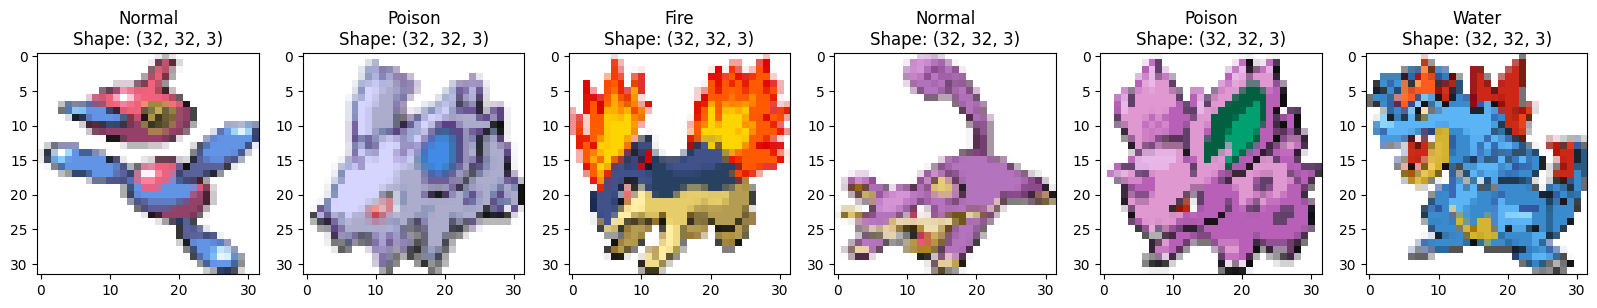

2024-07-14 09:28:23.513120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


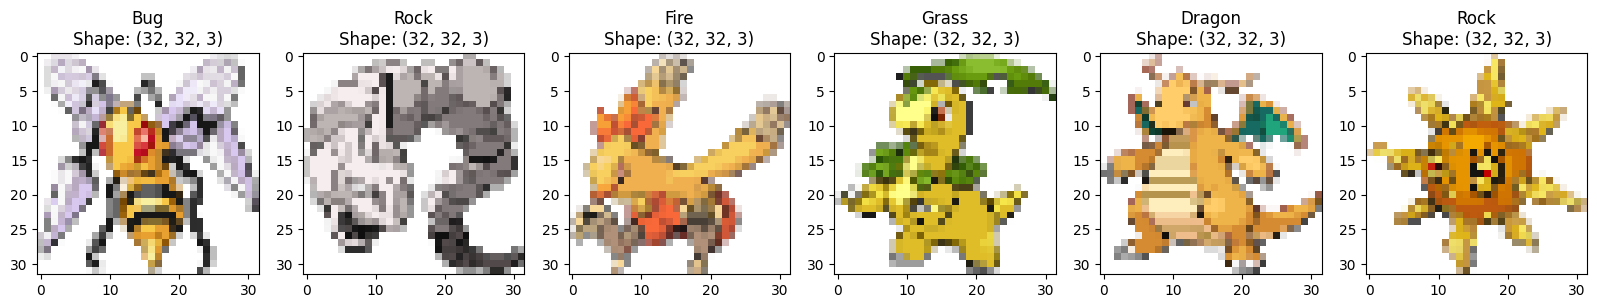

2024-07-14 09:28:23.755651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# train test split
# =====================================================================
train_poke_dataset, test_poke_dataset = tf.keras.utils.split_dataset(
    poke_dataset, left_size=0.96, shuffle=True
)

# Length of the datasets
print(f"- Train size: {len(train_poke_dataset) * BATCH_SIZE} sprites")
print(f"- Test size: {len(test_poke_dataset) * BATCH_SIZE} sprites")

# Plot
visualize.plot_images_batch(train_poke_dataset, 6)
visualize.plot_images_batch(test_poke_dataset, 6)

# 2. Modelo

Definimos el modelo usando la arquitectura **U-Net** y añadiendo las funcionalidades de un modelo de difusión con la clase `DiffusionModel()`. Además, se usa un modelo EMA (Exponential Moving Average) con el objetivo de mejorar el entrenamiento del modelo.

**Beneficios del EMA (Exponential Moving Average)**

1. **Estabilidad en la Predicción:** Las actualizaciones de los pesos de la red durante el entrenamiento pueden ser ruidosas y llevar a oscilaciones que afecten la estabilidad del modelo. Usar EMA de los pesos ayuda a suavizar estos cambios, resultando en una versión de los pesos que cambia más gradualmente y de manera más estable.

2. **Mejora en la Generalización:** Los pesos suavizados mediante EMA tienden a generalizar mejor en datos nuevos, lo que puede llevar a un mejor rendimiento en el conjunto de validación o de prueba. Esto se debe a que el EMA actúa como una forma de regularización, evitando que el modelo se ajuste demasiado a las fluctuaciones en el conjunto de datos de entrenamiento.

3. **Robustez ante el Ruido:** Al incorporar la historia de los pesos pasados de una manera suavizada, el EMA hace que la red sea menos sensible a actualizaciones ruidosas o gradientes espurios que pueden ocurrir durante el entrenamiento.

---

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, dropout_rate=0.1)
ema_u_net = build_unet(IMG_SIZE, NUM_CLASSES, dropout_rate=0.1) # EMA model for smoother training
ema_u_net.set_weights(u_net.get_weights()) # Initialize EMA model with the same weights

model = DiffusionModel(
    model=u_net,
    ema_model=ema_u_net,
    img_size=IMG_SIZE,
    num_classes=NUM_CLASSES,
    timesteps=TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    s=S,
    scheduler=SCHEDULER,
    ema=0.999
)

# Compile the model
# =====================================================================
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

## 2.1. Entrenamiento

Entrenamos el modelo con los `EPOCHS` definido como hiperparámetro en el `config.ini` y añadimos la funcionalidad de guardado y muestreo de imágenes durante el entrenamiento a través del callback `DiffusionCallback`.

Epoch 1/4000


/home/pqlza/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma'

 1/30 ━━━━━━━━━━━━━━━━━━━━ 28:16 58s/step - mae: 1.1101 - loss: 1.9516

I0000 00:00:1720949364.033365  218447 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1720949364.067697  218447 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - mae: 1.0452 - loss: 1.7327

I0000 00:00:1720949369.617534  219602 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 172 bytes spill stores, 172 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 66s 261ms/step - mae: 1.0437 - loss: 1.7279 - val_loss: 1.2617 - val_mae: 0.8944
Epoch 2/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.9030 - loss: 1.2869 - val_loss: 1.0869 - val_mae: 0.8306
Epoch 3/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.8400 - loss: 1.1126 - val_loss: 0.9919 - val_mae: 0.7936
Epoch 4/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.8008 - loss: 1.0112 - val_loss: 0.9304 - val_mae: 0.7689
Epoch 5/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7766 - loss: 0.9511 - val_loss: 0.8932 - val_mae: 0.7534
Epoch 6/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7562 - loss: 0.9021 - val_loss: 0.8458 - val_mae: 0.7327
Epoch 7/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7404 - loss: 0.8659 - val_loss: 0.8347 - val_mae: 0.7265
Epoch 8/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7238 - loss: 0.8290 - val_loss: 0.8010 - val_mae: 0.7111
Epoch 9/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/ste

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.68it/s]


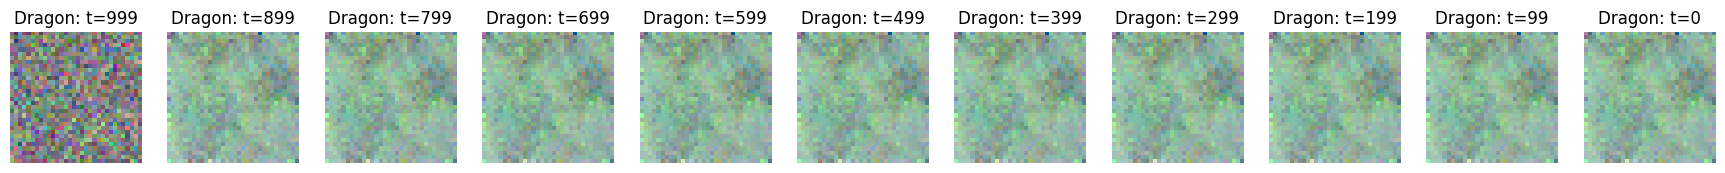

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.3246 - loss: 0.2112 - val_loss: 0.2087 - val_mae: 0.3181
Epoch 101/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3261 - loss: 0.2138 - val_loss: 0.2006 - val_mae: 0.3137
Epoch 102/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3274 - loss: 0.2159 - val_loss: 0.2024 - val_mae: 0.3164
Epoch 103/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3232 - loss: 0.2094 - val_loss: 0.2310 - val_mae: 0.3363
Epoch 104/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3243 - loss: 0.2124 - val_loss: 0.2042 - val_mae: 0.3209
Epoch 105/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3263 - loss: 0.2155 - val_loss: 0.2039 - val_mae: 0.3216
Epoch 106/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.3194 - loss: 0.2052 - val_loss: 0.2264 - val_mae: 0.3303
Epoch 107/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3192 - loss: 0.2080 - val_loss: 0.1992 - val_mae: 0.3140
Epoch 108/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.96it/s]


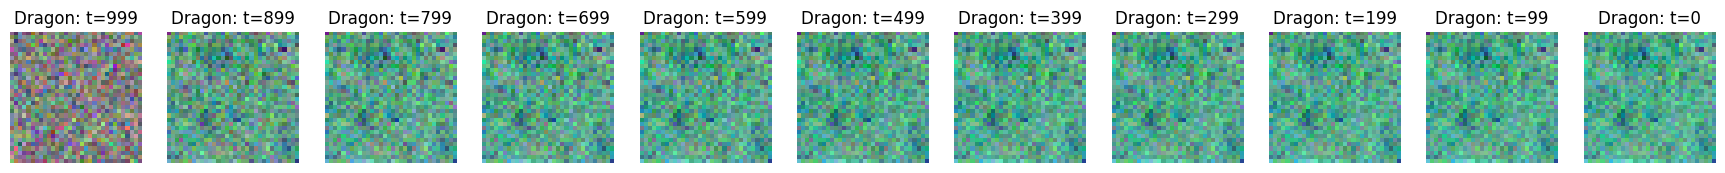

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.2718 - loss: 0.1648 - val_loss: 0.1561 - val_mae: 0.2647
Epoch 201/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2674 - loss: 0.1624 - val_loss: 0.1354 - val_mae: 0.2428
Epoch 202/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2667 - loss: 0.1597 - val_loss: 0.1584 - val_mae: 0.2586
Epoch 203/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2637 - loss: 0.1562 - val_loss: 0.1378 - val_mae: 0.2465
Epoch 204/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2660 - loss: 0.1596 - val_loss: 0.1747 - val_mae: 0.2709
Epoch 205/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2666 - loss: 0.1591 - val_loss: 0.1369 - val_mae: 0.2472
Epoch 206/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2648 - loss: 0.1580 - val_loss: 0.1427 - val_mae: 0.2456
Epoch 207/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2676 - loss: 0.1627 - val_loss: 0.1653 - val_mae: 0.2667
Epoch 208/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.75it/s]


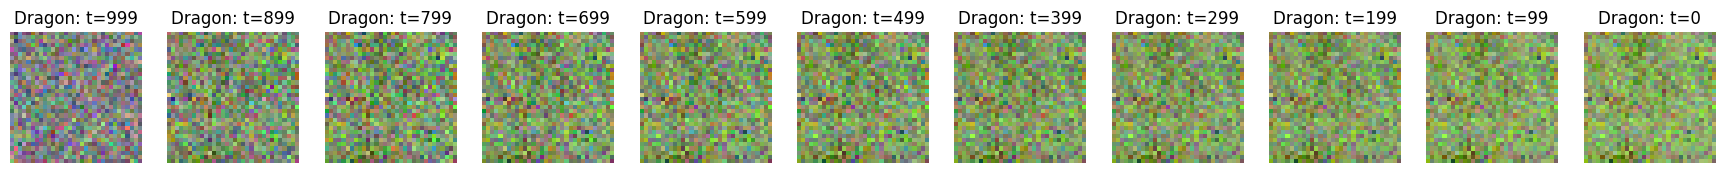

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.2386 - loss: 0.1373 - val_loss: 0.1436 - val_mae: 0.2425
Epoch 301/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2405 - loss: 0.1398 - val_loss: 0.1564 - val_mae: 0.2528
Epoch 302/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2401 - loss: 0.1397 - val_loss: 0.1282 - val_mae: 0.2314
Epoch 303/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2344 - loss: 0.1325 - val_loss: 0.1319 - val_mae: 0.2341
Epoch 304/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2349 - loss: 0.1329 - val_loss: 0.1063 - val_mae: 0.2042
Epoch 305/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2372 - loss: 0.1354 - val_loss: 0.1223 - val_mae: 0.2218
Epoch 306/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2407 - loss: 0.1410 - val_loss: 0.1366 - val_mae: 0.2369
Epoch 307/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2401 - loss: 0.1389 - val_loss: 0.1315 - val_mae: 0.2323
Epoch 308/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.55it/s]


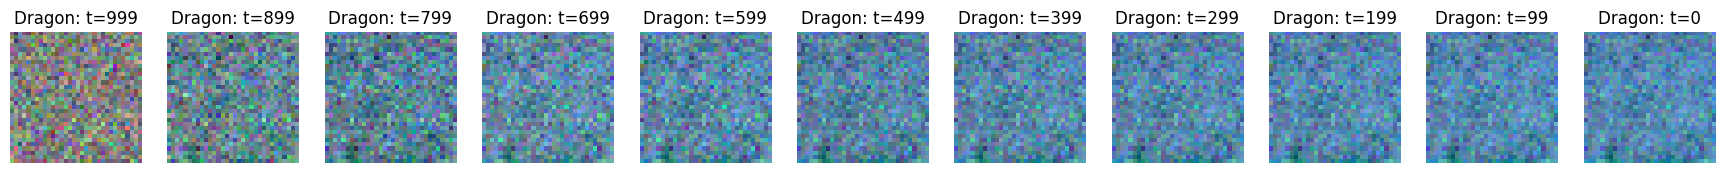

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.2247 - loss: 0.1260 - val_loss: 0.1261 - val_mae: 0.2251
Epoch 401/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2253 - loss: 0.1268 - val_loss: 0.1133 - val_mae: 0.2093
Epoch 402/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2322 - loss: 0.1361 - val_loss: 0.1076 - val_mae: 0.2052
Epoch 403/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2276 - loss: 0.1290 - val_loss: 0.1085 - val_mae: 0.2062
Epoch 404/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2270 - loss: 0.1297 - val_loss: 0.1239 - val_mae: 0.2198
Epoch 405/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2251 - loss: 0.1280 - val_loss: 0.1250 - val_mae: 0.2207
Epoch 406/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2268 - loss: 0.1289 - val_loss: 0.1199 - val_mae: 0.2158
Epoch 407/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2231 - loss: 0.1248 - val_loss: 0.1149 - val_mae: 0.2169
Epoch 408/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.61it/s]


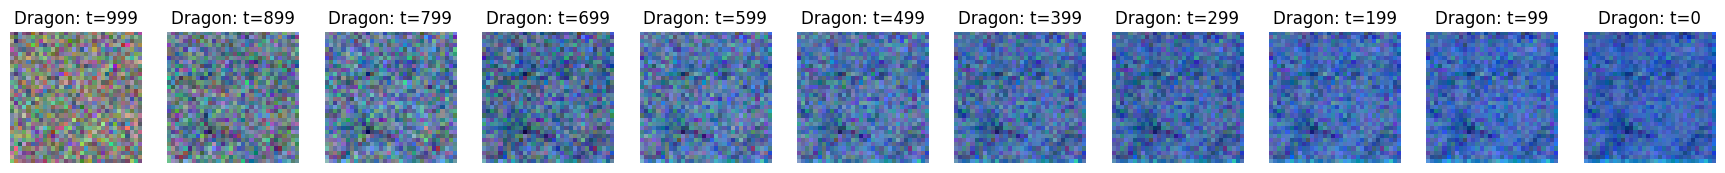

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.2236 - loss: 0.1282 - val_loss: 0.1269 - val_mae: 0.2158
Epoch 501/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2177 - loss: 0.1219 - val_loss: 0.1264 - val_mae: 0.2204
Epoch 502/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2169 - loss: 0.1203 - val_loss: 0.1318 - val_mae: 0.2215
Epoch 503/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2229 - loss: 0.1284 - val_loss: 0.1301 - val_mae: 0.2197
Epoch 504/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2197 - loss: 0.1229 - val_loss: 0.1205 - val_mae: 0.2125
Epoch 505/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2169 - loss: 0.1217 - val_loss: 0.1141 - val_mae: 0.2131
Epoch 506/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2218 - loss: 0.1275 - val_loss: 0.1030 - val_mae: 0.2007
Epoch 507/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2153 - loss: 0.1191 - val_loss: 0.1322 - val_mae: 0.2258
Epoch 508/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.76it/s]


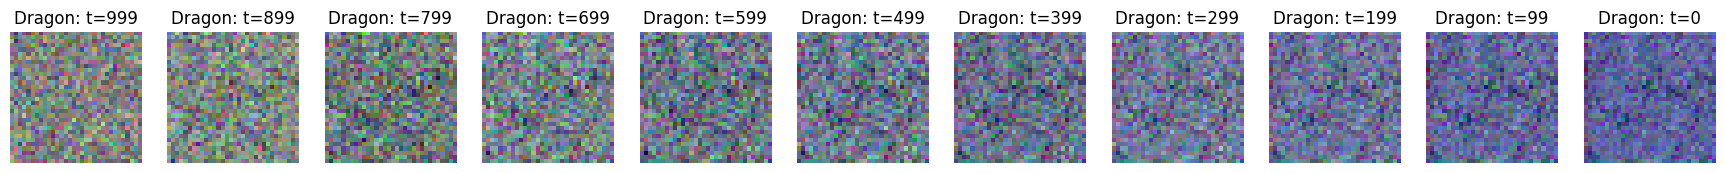

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.2127 - loss: 0.1185 - val_loss: 0.1126 - val_mae: 0.2047
Epoch 601/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2183 - loss: 0.1247 - val_loss: 0.1241 - val_mae: 0.2136
Epoch 602/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2106 - loss: 0.1166 - val_loss: 0.1320 - val_mae: 0.2213
Epoch 603/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2100 - loss: 0.1163 - val_loss: 0.1092 - val_mae: 0.2006
Epoch 604/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2114 - loss: 0.1169 - val_loss: 0.1252 - val_mae: 0.2154
Epoch 605/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2116 - loss: 0.1169 - val_loss: 0.1108 - val_mae: 0.2065
Epoch 606/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2075 - loss: 0.1127 - val_loss: 0.1243 - val_mae: 0.2078
Epoch 607/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2160 - loss: 0.1223 - val_loss: 0.1136 - val_mae: 0.2074
Epoch 608/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

In [7]:
# Train the model
# =====================================================================
diff_callback = DiffusionCallback(model, 100, "Dragon")
history = model.fit(
    train_poke_dataset,
    epochs=EPOCHS,
    validation_data=test_poke_dataset,
    callbacks=[diff_callback],
)

## 2.2. Evaluación del modelo

Una vez entrenado el modelo, lo evaluamos gracias al conjunto de testeo que definimos anteriormente. Para evaluar el entrenamiento del modelo se mostrarán la evolución de los valores de la función de perdida y las métricas a lo largo del entrenamiento. Todo ello, para garantizar el correcto entrenamiento del modelo de difusión, evitando su overfitting principalmente.

Y tal y como podemos observar el modelo no sufre de overfitting y ambas funciones tienen a minimizar el error cometido correctamente, por lo que podemos garantizar que el entrenamiento se ha realizado con éxito.

In [ ]:
visualize.plot_history(history)

## 2.3. Guardado del modelo

Finalmente, una vez comprobado el correcto entrenamiento del modelo, procedemos a guardarlo para futuras síntesis de imágenes sin necesidad de estar entrenando de nuevo el modelo. Los resultados finales se presentarán en el siguiente notebook.

In [ ]:
# Save the model
# =====================================================================
save_path = f"{MODELS_PATH}/final_diffusion_model_{EPOCHS}.weights.h5"
model.save_weights(save_path)

[BACK TO TOP](#top)